In [1]:
import os # need to happen before loading numpy
os.environ["OMP_NUM_THREADS"] = "8" # export OMP_NUM_THREADS=8
os.environ["OPENBLAS_NUM_THREADS"] = "8" # export OPENBLAS_NUM_THREADS=8
os.environ["MKL_NUM_THREADS"] = "8" # export MKL_NUM_THREADS=8
os.environ["VECLIB_MAXIMUM_THREADS"] = "8" # export VECLIB_MAXIMUM_THREADS=8
os.environ["NUMEXPR_NUM_THREADS"] = "8" # export NUMEXPR_NUM_THREADS=8

In [2]:
import sys
import dill
from collections import defaultdict
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from flow import Node, CreditFlow, Graph, get_source_nodes, topo_sort, flatten_graph, eval_graph, boundary_graph, single_source_graph, viz_graph, save_graph, hcluster_graph
from flow import ParallelCreditFlow, GraphExplainer, translator
from flow import group_nodes, build_feature_graph
from flow import CausalLinks, create_xgboost_f
from on_manifold import OnManifoldExplainer, IndExplainer

if '../shap' not in sys.path:
    sys.path = ['../shap'] + sys.path
    import shap
    
import tqdm
from numba import jit
import numpy as np
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl
from graphviz import Digraph, Source
from pygraphviz import AGraph
import numpy as np
import matplotlib.image as mpimg
from IPython.display import Image
import matplotlib.pyplot as plt
import copy
import seaborn as sns
import scipy as sp
import scipy.cluster
import matplotlib.pyplot as pl

# Train a model

In [3]:
X,y = shap.datasets.nhanesi()
X_display,y_display = shap.datasets.nhanesi(display=True) # human readable feature values
# remove the first column: unnamed: 0
X = X.iloc[:, 1:]
X_display = X_display.iloc[:, 1:]

xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

print(X.shape, X_display.shape)
X.head()

(9932, 18) (9932, 18)


,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
0,35.0,92.0,126.0,2.0,77.7,12.0,5.0,165.0,135.0,1.37,7.6,2.0,142.0,323.0,41.8,5.8,31.109434,50.0
1,71.0,78.0,210.0,2.0,77.7,37.0,4.0,298.0,89.0,1.38,6.4,2.0,156.0,331.0,26.9,5.3,32.362572,78.0
2,74.0,86.0,999.0,2.0,77.7,31.0,3.8,222.0,115.0,1.37,7.4,2.0,170.0,299.0,38.5,8.1,25.388497,84.0
3,64.0,92.0,385.0,1.0,77.7,30.0,4.3,265.0,94.0,1.97,7.3,2.0,172.0,349.0,26.9,6.7,26.446610,80.0
4,32.0,70.0,183.0,2.0,77.7,18.0,5.0,203.0,192.0,1.35,7.3,1.0,128.0,386.0,49.7,8.1,20.354684,58.0


In [4]:
# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
}
model_train = xgboost.train(params, xgb_train, 1000, evals = [(xgb_test, "test")], verbose_eval=100)

# workaround from https://github.com/slundberg/shap/issues/1215
mybooster = model_train

model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

[0]	test-cox-nloglik:7.26934
[100]	test-cox-nloglik:7.04554
[200]	test-cox-nloglik:6.90625
[300]	test-cox-nloglik:6.80909
[400]	test-cox-nloglik:6.73926
[500]	test-cox-nloglik:6.68686
[600]	test-cox-nloglik:6.64699
[700]	test-cox-nloglik:6.61571
[800]	test-cox-nloglik:6.59138
[900]	test-cox-nloglik:6.57148
[999]	test-cox-nloglik:6.55579


In [5]:
# train final model on the full data set
params = {
    "eta": 0.002,
    "max_depth": 3, 
    "objective": "survival:cox",
    "subsample": 0.5
}
model = xgboost.train(params, xgb_full, 1000, evals = [(xgb_full, "test")], verbose_eval=1000)

# workaround from https://github.com/slundberg/shap/issues/1215
mybooster = model

model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

[0]	test-cox-nloglik:8.88081
[999]	test-cox-nloglik:8.16748


In [6]:
def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels[j] > 0 and abs(labels[i]) > labels[j]:
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

# see how well we can order people by survival
c_statistic_harrell(model_train.predict(xgb_test, ntree_limit=5000), y_test)

0.8289463410825477

In [14]:
dill.dump(model, open("large_run_model.pkl", 'wb'))
# model = dill.load(open("large_run_model.pkl", 'wb'))

## Settings

In [7]:
n_bg = 1
bg = X.fillna(X.mean())[:1] # single baseline version
nsamples = 100 # number of fg samples to explain
nruns = 10000
sample_ind = 4 # sample ind for visualization

# Ind Shap

0it [00:00, ?it/s]


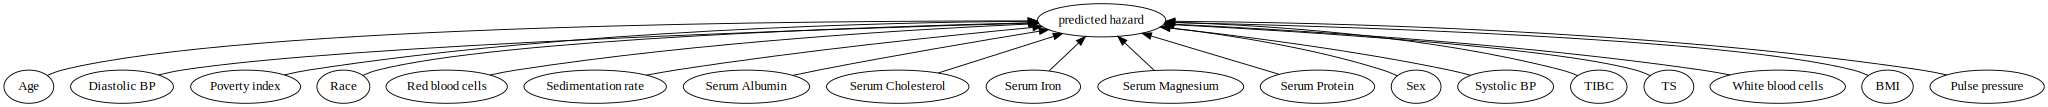

In [8]:
causal_links = CausalLinks()
categorical_feature_names = ['Race', 'Sex']
display_translator = translator(X.columns, X, X_display)
target_name = 'predicted hazard'
feature_names = list(X.columns)

# build causal links
causal_links.add_causes_effects(feature_names, target_name, create_xgboost_f(feature_names, model, output_margin=True)) # the target
graph = build_feature_graph(X.fillna(X.mean()), causal_links, categorical_feature_names, display_translator, target_name)
graph.draw()

In [9]:
# multiple baseline result
ind_edge_credit = defaultdict(lambda: defaultdict(int))
for i in range(len(bg)): # average run result using linearity axiom
    explainer = GraphExplainer(graph, bg[i:i+1], nruns=nruns) 
    cf = explainer.shap_values(X[:nsamples])

    for node1, d in cf.edge_credit.items(): # avg attribution
        for node2, val in d.items():
            a = ind_edge_credit[node1.name][node2.name]
            b = cf.edge_credit[node1][node2]
            ind_edge_credit[node1.name][node2.name] = (a * i + b) / (i + 1)

# need to do this because draw expect node based dict, not str based dict
def convert2node_dict(name_edge_credit, graph):
    name2node = {node.name: node for node in graph}
    res = defaultdict(lambda: defaultdict(int))
    for node1, d in name_edge_credit.items():
        for node2, val in d.items():
            res[name2node[node1]][name2node[node2]] = val
    return res

ind_edge_credit = convert2node_dict(ind_edge_credit, explainer.graph)

bruteforce sampling: 100%|██████████| 10000/10000 [09:06<00:00, 18.30it/s]


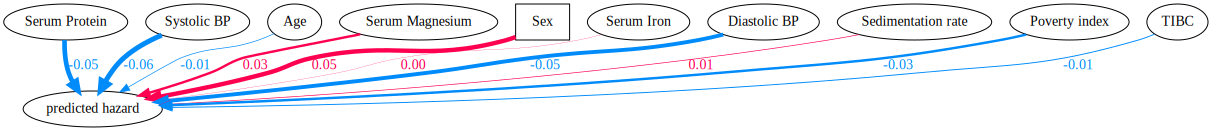

<AGraph <Swig Object of type 'Agraph_t *' at 0x7fb5821710c0>>

In [15]:
cf.edge_credit = ind_edge_credit
cf.draw(sample_ind, max_display=10, show_fg_val=False)

In [11]:
print(X.iloc[sample_ind])
print('target:', model.predict(xgboost.DMatrix(X.iloc[sample_ind:sample_ind+1]), output_margin=True)) # take the log
print('mean target:', model.predict(xgboost.DMatrix(bg[:2]), output_margin=True).mean()) # take the log

Age                    32.000000
Diastolic BP           70.000000
Poverty index         183.000000
Race                    2.000000
Red blood cells        77.700000
Sedimentation rate     18.000000
Serum Albumin           5.000000
Serum Cholesterol     203.000000
Serum Iron            192.000000
Serum Magnesium         1.350000
Serum Protein           7.300000
Sex                     1.000000
Systolic BP           128.000000
TIBC                  386.000000
TS                     49.700000
White blood cells       8.100000
BMI                    20.354684
Pulse pressure         58.000000
Name: 4, dtype: float64
target: [-1.834923]
mean target: -1.7217752


# On manifold SHAP

In [18]:
feature_names = X.columns
f = lambda x: model.predict(xgboost.DMatrix(pd.DataFrame(x, columns=feature_names)), output_margin=True) # wrapper for the model used by on manifold explainer

bg_samples = pd.concat([bg, X.fillna(X.mean()).sample(100)])
explainer = OnManifoldExplainer(f, bg_samples, nruns=nruns, sigma_sq=1e-1, single_bg=True) # single_bg so that it starts from the bg sample
cf_on_manifold = explainer.shap_values(X[:nsamples])

100%|██████████| 100/100 [14:33:47<00:00, 524.27s/it] 


In [19]:
# dill.dump(cf, open('nutrition_ind_large_run.pkl', 'wb'))
dill.dump(cf_on_manifold, open('nutrition_manifold_large_run.pkl', 'wb'))
# dill.dump(cf_c, open('nutrition_causal_large_run.pkl', 'wb'))

In [43]:
print('On manifold')
cf_on_manifold.draw(sample_ind, show=False, max_display=10)
plt.tight_layout()
# plt.savefig(f'figures/nutrition_manifold_{sample_ind}.png')
plt.show()
# cf_on_manifold.df(show=False, max_display=10)

On manifold


,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
0,-1.221376,-0.026819,1.164243,0.089721,0.213783,-0.006355,-0.188075,-0.117504,-0.308816,0.319943,0.052939,-0.419315,-0.111132,0.003375,0.268551,0.009265,0.369739,-0.042786


# incorporate causal relationship

In [60]:
causal_links = CausalLinks()
categorical_feature_names = ['Race', 'Sex']
display_translator = translator(X.columns, X, X_display)
target_name = 'predicted hazard'
feature_names = list(X.columns)

# build causal links
causal_links.add_causes_effects(feature_names, target_name, create_xgboost_f(feature_names, model, output_margin=True)) # the target uses log(HR) instead of HR
A = ['Diastolic BP', 'Systolic BP']
D = ['Pulse pressure'] # Systolic BP - Diastolic BP
causal_links.add_causes_effects(A, D, lambda dbp, sdp: sdp-dbp)
A = ['Age', 'Sex', 'Poverty index', 'Race']
D = list(set(feature_names) - set(A) - set(['Pulse pressure']))
causal_links.add_causes_effects(A, D)
A = ['Age', 'Sex', 'Race']
D = ['Poverty index']
causal_links.add_causes_effects(A, D)

causal_graph = build_feature_graph(X.fillna(X.mean()), causal_links, categorical_feature_names, display_translator, target_name)

learning dependency for Sedimentation rate:   0%|          | 0/14 [00:00<?, ?it/s]

[0]	test-rmse:19.38453
[100]	test-rmse:16.95487
[200]	test-rmse:15.09857
[300]	test-rmse:13.70687
[400]	test-rmse:12.67748
[499]	test-rmse:11.94172


learning dependency for White blood cells:   7%|▋         | 1/14 [00:00<00:08,  1.47it/s] 

[0]	test-rmse:7.24529
[100]	test-rmse:6.04540
[200]	test-rmse:5.08526
[300]	test-rmse:4.32187
[400]	test-rmse:3.72444
[499]	test-rmse:3.26567


learning dependency for TIBC:  14%|█▍        | 2/14 [00:01<00:07,  1.54it/s]             

[0]	test-rmse:365.08758
[100]	test-rmse:300.40860
[200]	test-rmse:247.82375
[300]	test-rmse:205.21208
[400]	test-rmse:170.85916
[499]	test-rmse:143.55504


learning dependency for Serum Magnesium:  21%|██▏       | 3/14 [00:01<00:06,  1.61it/s]

[0]	test-rmse:1.18907
[100]	test-rmse:0.97714
[200]	test-rmse:0.80443
[300]	test-rmse:0.66402
[400]	test-rmse:0.55023
[499]	test-rmse:0.45920


learning dependency for Serum Protein:  29%|██▊       | 4/14 [00:02<00:05,  1.75it/s]  

[0]	test-rmse:6.61101
[100]	test-rmse:5.42027
[200]	test-rmse:4.44728
[300]	test-rmse:3.65282
[400]	test-rmse:3.00507
[499]	test-rmse:2.48216


learning dependency for Serum Cholesterol:  36%|███▌      | 5/14 [00:02<00:04,  1.95it/s]

[0]	test-rmse:226.94263
[100]	test-rmse:187.87550
[200]	test-rmse:156.24815
[300]	test-rmse:130.78793
[400]	test-rmse:110.44482
[499]	test-rmse:94.44800


learning dependency for Systolic BP:  43%|████▎     | 6/14 [00:03<00:04,  1.86it/s]      

[0]	test-rmse:136.18751
[100]	test-rmse:112.07594
[200]	test-rmse:92.46083
[300]	test-rmse:76.55484
[400]	test-rmse:63.71541
[499]	test-rmse:53.49734


learning dependency for Poverty index:  50%|█████     | 7/14 [00:03<00:03,  1.81it/s]

[0]	test-rmse:365.16959
[100]	test-rmse:325.23489
[200]	test-rmse:295.42532
[300]	test-rmse:273.60983
[400]	test-rmse:257.95938
[499]	test-rmse:247.04848


learning dependency for BMI:  57%|█████▋    | 8/14 [00:04<00:03,  1.82it/s]          

[0]	test-rmse:25.68026
[100]	test-rmse:21.22700
[200]	test-rmse:17.61862
[300]	test-rmse:14.70853
[400]	test-rmse:12.38153
[499]	test-rmse:10.55001


learning dependency for Serum Albumin:  64%|██████▍   | 9/14 [00:04<00:02,  1.80it/s]

[0]	test-rmse:3.87407
[100]	test-rmse:3.17810
[200]	test-rmse:2.60949
[300]	test-rmse:2.14547
[400]	test-rmse:1.76748
[499]	test-rmse:1.46278


learning dependency for TS:  71%|███████▏  | 10/14 [00:05<00:02,  1.89it/s]           

[0]	test-rmse:29.79472
[100]	test-rmse:25.10775
[200]	test-rmse:21.40968
[300]	test-rmse:18.53344
[400]	test-rmse:16.33232
[499]	test-rmse:14.69491


learning dependency for Diastolic BP:  79%|███████▊  | 11/14 [00:06<00:01,  1.82it/s]

[0]	test-rmse:83.71987
[100]	test-rmse:68.93323
[200]	test-rmse:56.90493
[300]	test-rmse:47.15287
[400]	test-rmse:39.27799
[499]	test-rmse:33.00833


learning dependency for Red blood cells:  86%|████████▌ | 12/14 [00:06<00:01,  1.80it/s]

[0]	test-rmse:56.62017
[100]	test-rmse:47.20332
[200]	test-rmse:39.64856
[300]	test-rmse:33.63278
[400]	test-rmse:28.88807
[499]	test-rmse:25.23218


learning dependency for Serum Iron:  93%|█████████▎| 13/14 [00:07<00:00,  1.83it/s]     

[0]	test-rmse:105.80270
[100]	test-rmse:88.86579
[200]	test-rmse:75.45215
[300]	test-rmse:64.97789
[400]	test-rmse:56.92674
[499]	test-rmse:50.90213


learning dependency for Serum Iron: 100%|██████████| 14/14 [00:07<00:00,  1.82it/s]


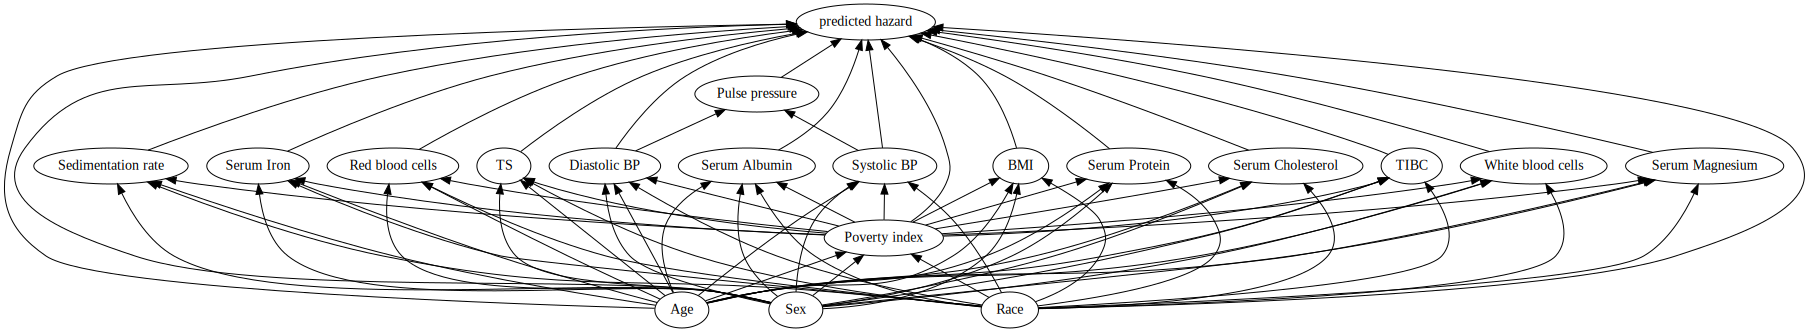

In [61]:
causal_graph.draw()

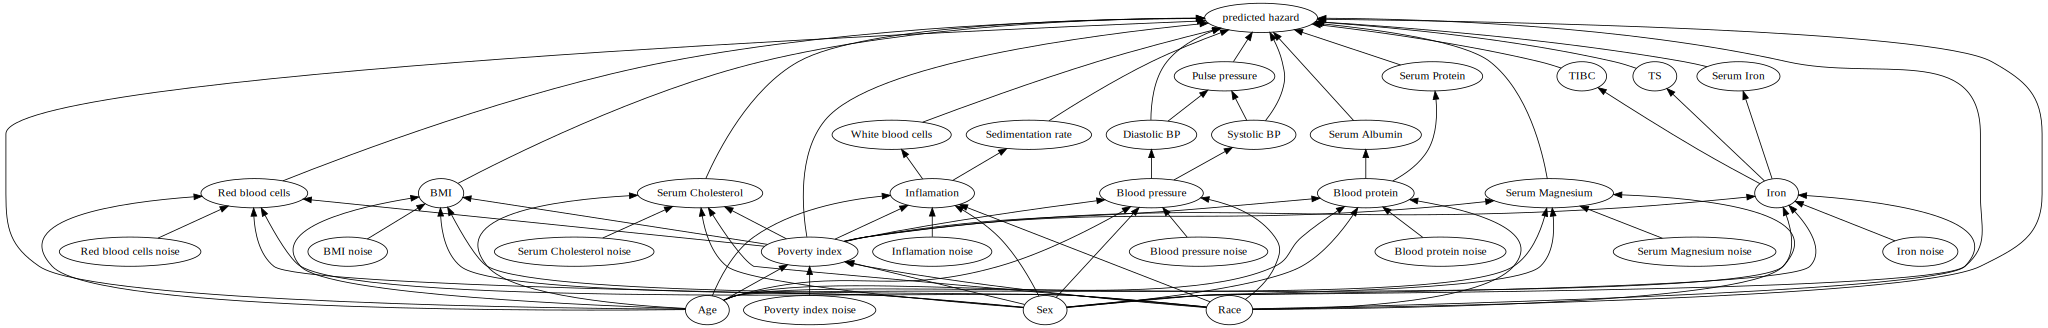

In [73]:
# for multiple baseline need to run this multiple times, finally I can just combine the different baselines because of linearity
E = GraphExplainer(causal_graph, bg[:1])
E.prepare_graph(X) # add noise node
G = copy.deepcopy(E.graph) # group happens after noise node b/c the grouped nodes combines individual noise node
G = group_nodes(G, [n for n in G if n.name in ['White blood cells', 'Sedimentation rate']], 'Inflamation')
G = group_nodes(G, [n for n in G if n.name in ['Systolic BP', 'Diastolic BP']], 'Blood pressure')
G = group_nodes(G, [n for n in G if n.name in ['TS', 'TIBC', 'Serum Iron']], 'Iron')
G = group_nodes(G, [n for n in G if n.name in ['Serum Protein', 'Serum Albumin']], 'Blood protein')
G.draw()

In [75]:
# multiple baseline result
causal_edge_credit = defaultdict(lambda: defaultdict(int))
for i in range(len(bg)):
    print(f'bg run {i}')
    E = GraphExplainer(causal_graph, bg[i:i+1])
    E.prepare_graph(X) # add noise node
    G = copy.deepcopy(E.graph) # group happens after noise node b/c the grouped nodes combines individual noise node
    G = group_nodes(G, [n for n in G if n.name in ['White blood cells', 'Sedimentation rate']], 'Inflamation')
    G = group_nodes(G, [n for n in G if n.name in ['Systolic BP', 'Diastolic BP']], 'Blood pressure')
    G = group_nodes(G, [n for n in G if n.name in ['TS', 'TIBC', 'Serum Iron']], 'Iron')
    G = group_nodes(G, [n for n in G if n.name in ['Serum Protein', 'Serum Albumin']], 'Blood protein')
    
    explainer = GraphExplainer(G, bg[i:i+1], nruns=nruns) 
    cf_c = explainer.shap_values(X[:nsamples], skip_prepare=True)

    # combine credits
    for node1, d in cf_c.edge_credit.items():
        for node2, val in d.items():
            a = causal_edge_credit[node1.name][node2.name]
            b = cf_c.edge_credit[node1][node2]
            causal_edge_credit[node1.name][node2.name] = (a * i + b) / (i + 1)

# need to do this because draw expect node based dict, not str based dict
causal_edge_credit = convert2node_dict(causal_edge_credit, explainer.graph)

bruteforce sampling: 100%|██████████| 100/100 [16:57<00:00, 10.17s/it]


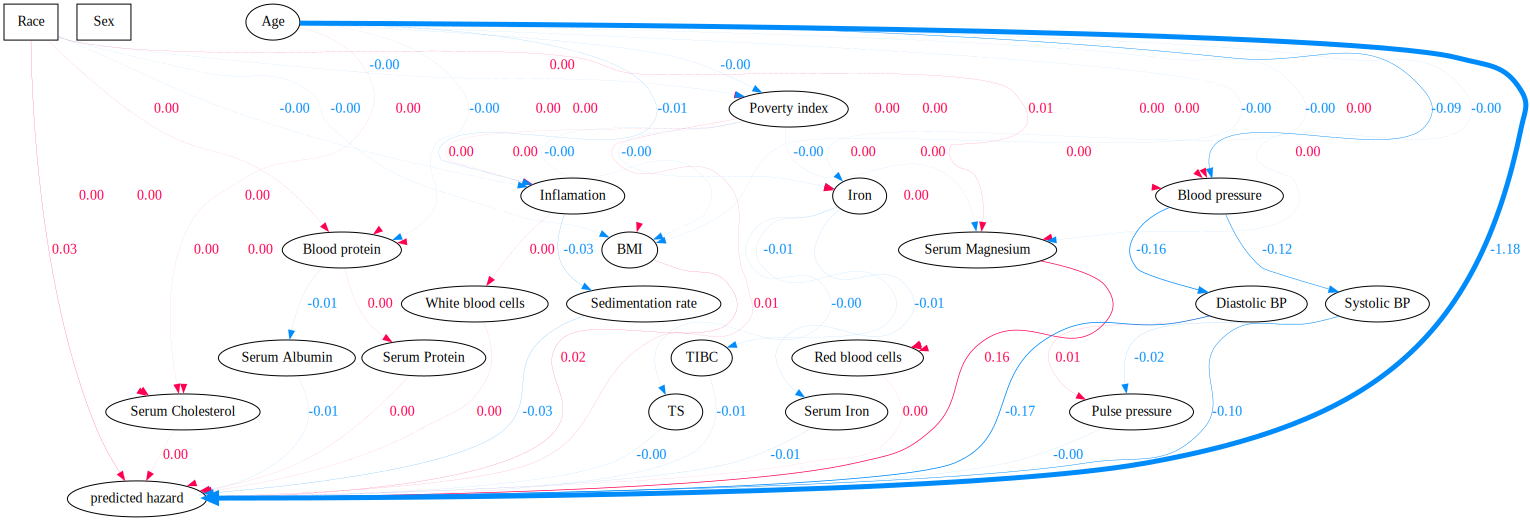

<AGraph <Swig Object of type 'Agraph_t *' at 0x7f12f9fd5210>>

In [81]:
cf_c.draw(sample_ind, max_display=None, show_fg_val=False, edge_credit=causal_edge_credit)

# Methods comparison

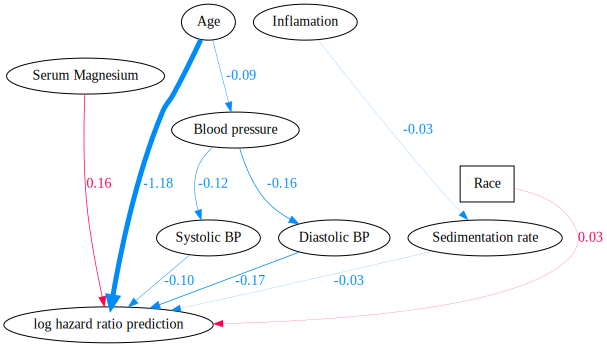

In [82]:
sample_ind = 4 # 55, 66, 3, 22, 33, 77, 88, 99 # 22 77 88
cf_c.fold_noise = True # False
target_node = [node for node in cf_c.graph if node.is_target_node][0]
target_node.name = 'log hazard ratio prediction'
g = cf_c.draw(sample_ind, max_display=10, show_fg_val=False, edge_credit=causal_edge_credit)
# save_graph(g, f'figures/nutrition_flow_{sample_ind}.png')

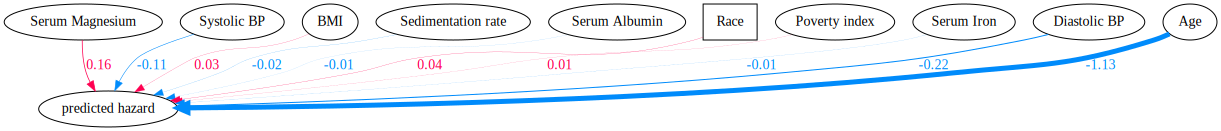

<AGraph <Swig Object of type 'Agraph_t *' at 0x7f13642e7a50>>

In [83]:
cf.draw(sample_ind, max_display=10, show_fg_val=False, edge_credit=ind_edge_credit)

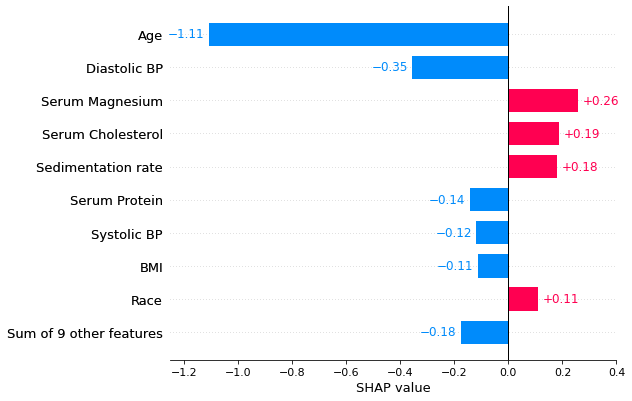

In [84]:
cf_on_manifold.draw(sample_ind, max_display=10) #, show_fg_val=False)

# investigate the background and foreground samples

In [136]:
print('baseline', model.predict(xgboost.DMatrix(X.iloc[0:1])))
print('target:', model.predict(xgboost.DMatrix(X.iloc[sample_ind:sample_ind+1])))
X_display.iloc[[0, sample_ind]]

baseline [0.17874856]
target: [0.8139746]


,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
0,35.0,92.0,126.0,2.0,77.7,12.0,5.0,165.0,135.0,1.37,7.6,Female,142.0,323.0,41.8,5.8,31.109434,50.0
3,64.0,92.0,385.0,1.0,77.7,30.0,4.3,265.0,94.0,1.97,7.3,Female,172.0,349.0,26.9,6.7,26.446610,80.0


In [137]:
print(X_display.iloc[[0, sample_ind]].rename(index={0: 'Background sample', sample_ind: 'Foreground sample'}).T.to_latex())

\begin{tabular}{lll}
\toprule
{} & Background sample & Foreground sample \\
\midrule
Age                &                35 &                64 \\
Diastolic BP       &                92 &                92 \\
Poverty index      &               126 &               385 \\
Race               &                 2 &                 1 \\
Red blood cells    &              77.7 &              77.7 \\
Sedimentation rate &                12 &                30 \\
Serum Albumin      &                 5 &               4.3 \\
Serum Cholesterol  &               165 &               265 \\
Serum Iron         &               135 &                94 \\
Serum Magnesium    &              1.37 &              1.97 \\
Serum Protein      &               7.6 &               7.3 \\
Sex                &            Female &            Female \\
Systolic BP        &               142 &               172 \\
TIBC               &               323 &               349 \\
TS                 &              41.8 &       

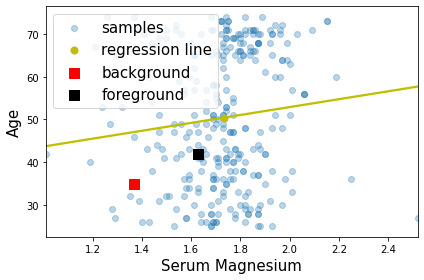

In [162]:
nsamples = 300
o = f(np.array(X)[:nsamples])
def normalize(o): # normalize to 0-1
    return (o - o.min()) / (o.max() - o.min())

# ylabel = 'Serum Magnesium' # 'Serum Magnesium' # 'TIBC' #'Red blood cells' # 'Serum Iron' # 'Serum Protein' # 'Serum Cholesterol' # 'Diastolic BP'
# xlabel = 'Age' #'Age'

ylabel = 'Age'
xlabel = 'Serum Magnesium'

plt.scatter(X[xlabel][:nsamples], X[ylabel][:nsamples], #c=normalize(o), 
            alpha=0.3, label='samples')
sns.regplot(X[xlabel][:nsamples], X[ylabel][:nsamples], x_bins=1, order=1, ci=None, label='regression line', color='y')
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)

plt.scatter(X[xlabel][[0]], X[ylabel][[0]], c=['red'], s=100, marker='s', label='background')
plt.scatter(X[xlabel][[sample_ind]], X[ylabel][[sample_ind]], c=['black'], s=100, marker='s', label='foreground')
plt.legend(fontsize=15, loc="upper left")

plt.tight_layout()
# plt.savefig(f'figures/manifold_explain_age_{xlabel}.png')
plt.show()

This is a clear example of why on manifold perturabtion can be extremely misleading! Given Serum Magnesium level of 1.6, the algorithm expect an age of near 50, but when the actual age is revealed, we see a pleasant surprise that lowers the risk! But Age certainty is not a protective attribute! ASV and Flow wouldn't try this order (Serum Magnesium followed by Age).

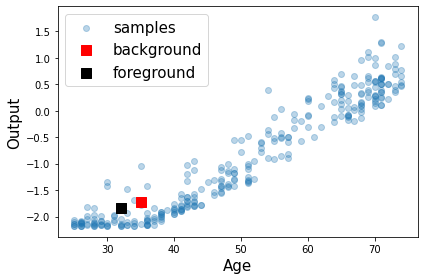

In [40]:
nsamples = 300
o = f(np.array(X)[:nsamples])

xlabel = 'Age'
ylabel = 'Output'
plt.scatter(X[xlabel][:nsamples], o, alpha=0.3, label='samples')
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.scatter(X[xlabel][[0]], o[[0]], c=['red'], s=100, marker='s', label='background')
plt.scatter(X[xlabel][[sample_ind]], o[[sample_ind]], c=['black'], s=100, marker='s', label='foreground')
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('figures/manifold_age.png')
plt.show()

# Output to latex

In [410]:
latex_dict = {}

# asv
def prepare_bar_asv(target_node, edge_credit, sample_ind):
    '''prepare into barchart format for shap'''
    class D():
        pass

    b = D()
    b.input_names = [i for i in edge_credit.keys() if hasattr(i, 'is_target_node')]
    b.values = [edge_credit[i][target_node] for i in b.input_names]
    b.input_names = list(map(str, b.input_names))
    b.data = None #np.arange(len(b.input_names))
    b.transform_history = []
    return b

target_node = [i for i in cf_c.graph if i.is_target_node][0]
edge_credit = cf_c.get_asv_edge_credit(sample_ind)
b = prepare_bar_asv(target_node, edge_credit, sample_ind)
latex_dict['asv'] = {k:v for k,v in zip(map(lambda n: n[:-6] if n[-5:] == 'noise' else n,
                                            b.input_names), 
                                        b.values)}

# shap
def prepare_bar_shap(target_node, edge_credit, sample_ind):
    '''prepare into barchart format for shap'''
    class D():
        pass

    b = D()
    b.input_names = [i for i in edge_credit.keys() if hasattr(i, 'is_target_node')]
    b.values = [edge_credit[i][target_node][sample_ind] for i in b.input_names]
    b.input_names = list(map(str, b.input_names))
    b.data = None # np.arange(len(b.input_names))
    b.transform_history = []
    return b

target_node = [i for i in cf.graph if i.is_target_node][0]
edge_credit = cf.edge_credit
b = prepare_bar_shap(target_node, edge_credit, sample_ind)
latex_dict['ind'] = {k:v for k,v in zip(b.input_names, b.values)}

# on manifold
def prepare_on_manifold(cf, sample_ind):
    class D(): pass
    b.input_names = cf.input_names
    b.values = cf.values[sample_ind]
    return b

b = prepare_on_manifold(cf_on_manifold, sample_ind)
latex_dict['manifold'] = {k:v for k,v in zip(b.input_names, b.values)}

# resulting data frame
df = pd.DataFrame.from_dict(latex_dict).loc[:, ['ind', 'manifold', 'asv']]
df = df.fillna(0)
# df.loc[:, 'asv'] = df.loc[:, 'asv'].fillna(0)
print(df.round(2).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &   ind &  manifold &   asv \\
\midrule
Race               &  0.00 &      0.05 &  0.00 \\
Blood pressure     &  0.00 &      0.00 & -0.12 \\
Age                &  0.04 &     -0.20 &  0.09 \\
Inflamation        &  0.00 &      0.00 & -0.00 \\
Sex                &  0.00 &     -0.03 &  0.00 \\
Serum Magnesium    & -0.21 &      0.02 & -0.21 \\
BMI                & -0.00 &      0.02 & -0.00 \\
Poverty index      & -0.02 &      0.04 & -0.02 \\
Serum Cholesterol  &  0.00 &      0.02 &  0.00 \\
Blood protein      &  0.00 &      0.00 & -0.05 \\
Iron               &  0.00 &      0.00 &  0.12 \\
Red blood cells    &  0.00 &      0.04 &  0.00 \\
Sedimentation rate &  0.00 &      0.01 &  0.00 \\
Diastolic BP       & -0.03 &      0.01 &  0.00 \\
Serum Albumin      &  0.00 &      0.03 &  0.00 \\
Serum Protein      & -0.05 &      0.05 &  0.00 \\
TS                 &  0.09 &     -0.11 &  0.00 \\
Pulse pressure     &  0.00 &     -0.04 &  0.00 \\
White blood cells  & -0.00

In [434]:
colors = np.array(df.fillna(0))

# normalize each column by the largest absolute value
for i in range(colors.shape[1]):
    colors[:, i] /= np.abs(colors[:, i]).max()
    colors[:, i] *= 100
colors = colors.astype(np.int)

# sort index by its abs score across columns
feature_order = np.abs(colors).sum(1).argsort()[::-1]
# colors

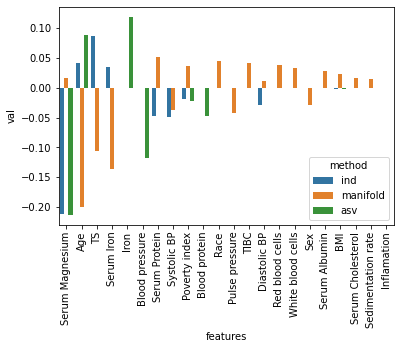

In [442]:
df2 = pd.DataFrame.from_dict({
    'features': list(df.iloc[feature_order].index) * 3,
    'val': list(df['ind'].iloc[feature_order]) + list(df['manifold'].iloc[feature_order]) + list(df['asv'].iloc[feature_order]),
    'method': ['ind'] * len(df.index) + ['manifold'] * len(df.index) + ['asv'] * len(df.index)
})

p = sns.barplot(x='features', y='val', hue='method', data=df2)
p.set_xticklabels(p.get_xticklabels(), rotation=90)
plt.show()

In [443]:
table = "\\begin{tabular}{lrrr}\n\\toprule\n"
table += r"{} & Independent & On-manifold & ASV\\"
table += "\n\\midrule\n"
for i in feature_order:
    row = []
    feature_name = df.iloc[i].name
    row.append(feature_name)
    for j in range(colors.shape[1]):
        v = df.iloc[i, j].round(2)
        c = "blue" if colors[i, j] < 0 else "red"
        c = f"\\cellcolor{{{c}!{np.abs(colors[i,j])}}}"
        row.append(f"{c} {v}")
    table += r" & ".join(row)
    table += "\\\\\n"
table += "\\bottomrule\n\\end{tabular}"
print(table)

\begin{tabular}{lrrr}
\toprule
{} & Independent & On-manifold & ASV\\
\midrule
Serum Magnesium & \cellcolor{blue!100} -0.21 & \cellcolor{red!8} 0.02 & \cellcolor{blue!100} -0.21\\
Age & \cellcolor{red!19} 0.04 & \cellcolor{blue!100} -0.2 & \cellcolor{red!41} 0.09\\
TS & \cellcolor{red!40} 0.09 & \cellcolor{blue!53} -0.11 & \cellcolor{red!0} 0.0\\
Serum Iron & \cellcolor{red!16} 0.04 & \cellcolor{blue!67} -0.14 & \cellcolor{red!0} 0.0\\
Iron & \cellcolor{red!0} 0.0 & \cellcolor{red!0} 0.0 & \cellcolor{red!55} 0.12\\
Blood pressure & \cellcolor{red!0} 0.0 & \cellcolor{red!0} 0.0 & \cellcolor{blue!55} -0.12\\
Serum Protein & \cellcolor{blue!22} -0.05 & \cellcolor{red!26} 0.05 & \cellcolor{red!0} 0.0\\
Systolic BP & \cellcolor{blue!22} -0.05 & \cellcolor{blue!18} -0.04 & \cellcolor{red!0} 0.0\\
Poverty index & \cellcolor{blue!9} -0.02 & \cellcolor{red!17} 0.04 & \cellcolor{blue!10} -0.02\\
Blood protein & \cellcolor{red!0} 0.0 & \cellcolor{red!0} 0.0 & \cellcolor{blue!22} -0.05\\
Race & \c

# Save and loading

In [185]:
import dill
# dill.dump(cf, open('NHANES1_cf_ind.pkl', 'wb'))
# dill.dump(cf_c, open('NHANES1_cf_flow.pkl', 'wb'))
# dill.dump(cf_on_manifold, open('NHANES1_cf_manifold.pkl', 'wb'))

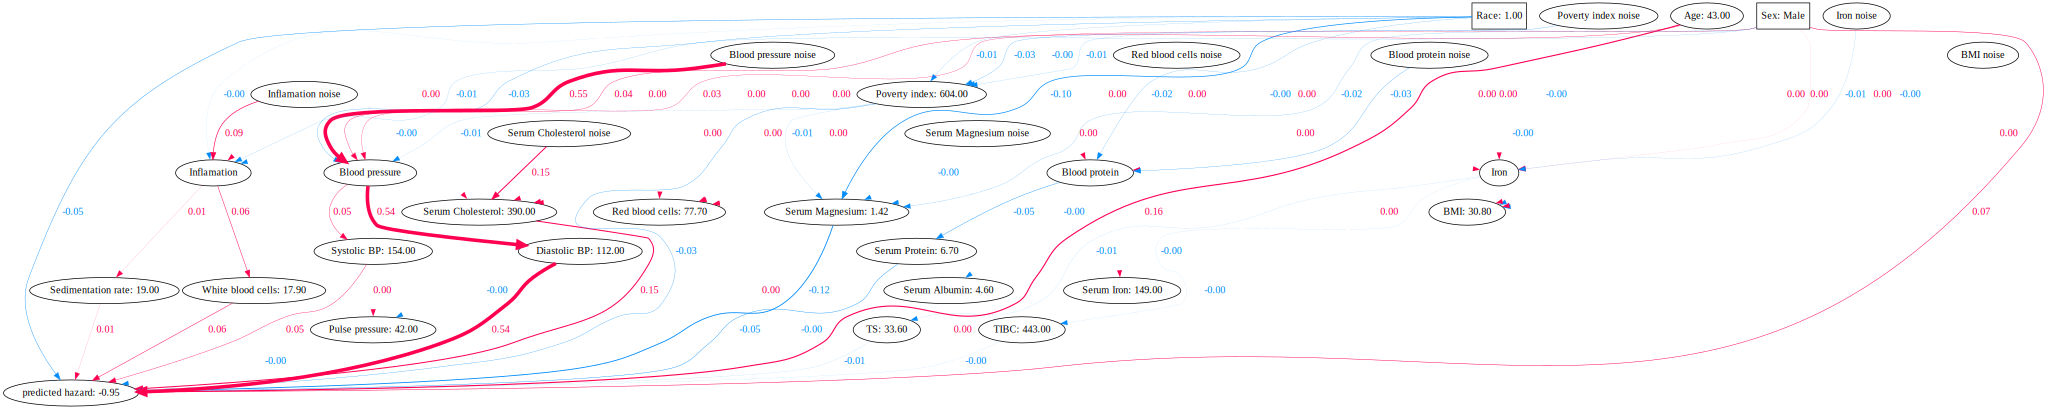

<AGraph <Swig Object of type 'Agraph_t *' at 0x7fc72ddc37b0>>

In [186]:
dill.load(open('NHANES1_cf_flow.pkl', 'rb')).draw(66)